This notebook does the following:

    Generate random walk polymer chain
    Generate polymer matrix using packmol
    Generate LAMMPS input files
    Run LAMMPS
    Post-process: compute diffusivity and rdf

Dependencies:

    pymatgen(latest development version from github or atleast v3.7.1)
    pymatgen-diffusion(https://github.com/materialsvirtuallab/pymatgen-diffusion): to compute RDF
    packmol(https://github.com/leandromartinez98/packmol)
    LAMMPS(http://lammps.sandia.gov)

Required input files:

    Input structures: start, bulk and terminal molecules
    Forcefield data: yaml file
    Input file template: json file

In [1]:
import numpy as np

from pprint import pprint

from pymatgen import Molecule
from pymatgen.io.babel import BabelMolAdaptor
from pymatgen.io.lammps.utils import Polymer, PackmolRunner, LammpsRunner

# Set the start, bulk, and terminal molecules. 

Set charges and optionally the forcefield species name mapping 

In [2]:
# start molecule
peo_start = Molecule.from_file("test_files/peo_start.xyz")
s_charges = [-0.1187, 0.0861, 0.0861, 0.0861, -0.2792, -0.0326, 0.0861, 0.0861]
peo_start.add_site_property("charge", s_charges)
s_head = 0
s_tail = 5

# chain molecule
peo_bulk = Molecule.from_file("test_files/peo_bulk.xyz")
b_charges = [-0.0326, 0.0861, 0.0861, -0.2792, -0.0326, 0.0861, 0.0861]
peo_bulk.add_site_property("charge", b_charges)
head = 0
tail = 4

# terminal molecule
peo_end = Molecule.from_file("test_files/peo_end.xyz")
e_charges = [-0.0326, 0.0861, 0.0861, -0.2792, -0.1187, 0.0861, 0.0861, 0.0861]
peo_end.add_site_property("charge", e_charges)
e_head = 0
e_tail = 4

# Create polymer via random walk

In [3]:
n_units = 58
link_distance = 1.5075

# create the polymer
peo_polymer = Polymer(peo_start, s_head, s_tail, 
                      peo_bulk, head, tail, 
                      peo_end, e_head, e_tail, 
                      n_units, link_distance)

# linear chain
peo_polymer_linear = Polymer(peo_start, s_head, s_tail, 
                             peo_bulk, head, tail, 
                             peo_end, e_head, e_tail, 
                             n_units, link_distance, linear_chain=True)

# Set the topology of the polymer from the linear chain

In [4]:
from pymatgen.io.lammps.topology import Topology

topology = Topology.from_molecule(peo_polymer_linear.molecule)

natoms, nbonds, nangles, ndih =  len(topology.atoms), len(topology.bonds), len(topology.angles), len(topology.dihedrals)

print(natoms, nbonds, nangles, ndih)

(408, 407, 754, 861)


# Generate polymer matrix

In [5]:
# constituent molecules
molecules = [peo_polymer.molecule]
#Polymer matrix settings
matrix_config = [{"number": 1, "inside box":[0,0,0,100,100,100]}]

# Use Packmol to pack the polymer chains into a box

In [6]:
pmr = PackmolRunner(molecules,
                    matrix_config,
                    tolerance=2.0,
                    filetype="xyz",
                    control_params={"nloop": 1000},
                    output_file="poly_packed.xyz")
packed_polymer = pmr.run()

packed molecule written to poly_packed.xyz


# Read in the force field parameters

In [7]:
from pymatgen.io.lammps.force_field import ForceField

forcefield = ForceField.from_file("ff_data.yaml")

# Generate lammps data file from the topology and the forcefield

In [8]:
from pymatgen.io.lammps.data import LammpsForceFieldData

mols_number = [mol_config["number"] for mol_config in matrix_config]
box_size = [[0.0, 100], 
            [0.0, 100], 
            [0.0, 100]]

# list of molecular topologies for each constituent molecules
topologies = [topology]*len(molecules)

lammps_ff_data = LammpsForceFieldData.from_forcefield_and_topology(molecules, mols_number, 
                                                                   box_size, packed_polymer, 
                                                                   forcefield, topologies)
#write the data file
#lammps_ff_data.write_data_file("lammps_data.dat")

# Setup input file

In [9]:
from pymatgen.io.lammps.input import DictLammpsInput

job_name = "NPT"
input_template_file = "NPT.json"
input_filename = "peo.in"
data_filename = "peo.data"
log_filename = "peo.log"
dump_filename = "peo.dump"
dcd_traj_filename = "peo.dcd"
dump_freq = 50
T = [300, 300, 100.0] # start, end, damp
P = [0, 0, 100.0]

#override default settings read from the json file with these
user_settings = {"log": log_filename,
                 "pair_style": "buck/coul/cut 15.0", 
                 "pair_coeff": ["1 1 2649.6 0.2674 27.22",
                                "1 2 4320.0 0.2928 137.6",
                                "1 3 14176.0 0.2563 104.0",
                                "2 2 14976.0 0.3236 637.6",
                                "2 3 33702.4 0.2796 503.0",
                                "3 3 75844.8 0.2461 396.9"],
                 "thermo_style": "custom step time temp press pe ke etotal enthalpy fmax fnorm",
                 "fix": "NPT all npt temp {T[0]} {T[1]} {T[2]} iso {P[0]} {P[1]} {P[2]}".format(T=T, P=P),
                 "dump": ["peodump all custom {} {} id type x y z ix iy iz mol".format(dump_freq, dump_filename),
                          "traj all dcd {} {}".format(dump_freq, dcd_traj_filename)]}

lammps_input = DictLammpsInput.from_file(job_name, input_template_file, 
                                         lammps_data=lammps_ff_data, 
                                         data_filename=data_filename, 
                                         user_lammps_settings=user_settings)
print str(lammps_input)

log  peo.log
units  real
dimension  3
atom_style  full
boundary  p p p
neighbor  10.0 bin
bond_style  harmonic
angle_style  harmonic
dihedral_style  opls
read_data  peo.data
pair_style  buck/coul/cut 15.0
pair_coeff 1 1 2649.6 0.2674 27.22
pair_coeff 1 2 4320.0 0.2928 137.6
pair_coeff 1 3 14176.0 0.2563 104.0
pair_coeff 2 2 14976.0 0.3236 637.6
pair_coeff 2 3 33702.4 0.2796 503.0
pair_coeff 3 3 75844.8 0.2461 396.9
dump peodump all custom 50 peo.dump id type x y z ix iy iz mol
dump traj all dcd 50 peo.dcd
thermo_style  custom step time temp press pe ke etotal enthalpy fmax fnorm
thermo  100
fix  NPT all npt temp 300 300 100.0 iso 0 0 100.0
run  1000



# Run Lammps

In [10]:
#brandon's binary
#lammps_bin = 'mpiexec -n 2 lammps'

# binary compiled with openmpi, from ubuntu repo
#lammps_bin = 'lammps-daily'

# serial binary, compiled from source
lammps_bin = 'lmp_serial'

lammps = LammpsRunner(lammps_input, input_filename=input_filename, bin=lammps_bin)
lammps.run()

Data file: peo.data
Input file: peo.in
Running: lmp_serial -in peo.in
Done
LAMMPS (18 Jun 2016)
Reading data file ...
  orthogonal box = (0 0 0) to (100 100 100)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  408 atoms
  scanning bonds ...
  4 = max bonds/atom
  scanning angles ...
  6 = max angles/atom
  scanning dihedrals ...
  9 = max dihedrals/atom
  reading bonds ...
  407 bonds
  reading angles ...
  754 angles
  reading dihedrals ...
  861 dihedrals
Finding 1-2 1-3 1-4 neighbors ...
 Special bond factors lj:   0          0          0         
 Special bond factors coul: 0          0          0         
  4 = max # of 1-2 neighbors
  6 = max # of 1-3 neighbors
  12 = max # of 1-4 neighbors
  14 = max # of special neighbors
Neighbor list info ...
  1 neighbor list requests
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 25
  ghost atom cutoff = 25
  binsize = 12.5, bins = 8 8 8
Setting up Verle

# Post-processing

In [11]:
from pymatgen.io.lammps.output import LammpsRun
from pymatgen_diffusion.aimd.van_hove import RadialDistributionFunction

%matplotlib inline

In [12]:
lammpsrun = LammpsRun(data_filename, dump_filename, log_filename, is_forcefield=True)

# Get diffusion statistics summary

In [13]:
specie = "C"
temperature = T[0]
# Time step between measurements.
time_step = 1 
# Sampling frequency of the displacements 
#(time_step is multiplied by this number to get the real time between measurements)
step_skip = dump_freq
smoothed = None
min_obs = 30
avg_nsteps=1000

diffusion_analyzer = lammpsrun.get_diffusion_analyzer(specie, temperature, time_step, 
                                                      step_skip, smoothed=smoothed, 
                                                      min_obs=min_obs, avg_nsteps=avg_nsteps)
diffusion_analyzer.get_summary_dict()

{u'D': 7.7584089283089976e-05,
 u'D_components': [8.766374333210014e-05,
  6.449898511268146e-05,
  8.05895394044884e-05],
 u'D_components_sigma': [6.850309985408479e-06,
  7.188521527450217e-06,
  6.325117585193328e-06],
 u'D_sigma': 4.3176788887985503e-06,
 u'S': 223.10383944566166,
 u'S_components': [252.08928658305973, 185.47580247389982, 231.7464292800256],
 u'S_components_sigma': [19.699019132144365,
  20.67159346112854,
  18.18875533942081],
 u'S_sigma': 12.416086165161584,
 u'max_framework_displacement': 5.9483204143014508,
 u'specie': 'C',
 u'step_skip': 50,
 u'temperature': 300,
 u'time_step': 1}

# Compute and plot RDF

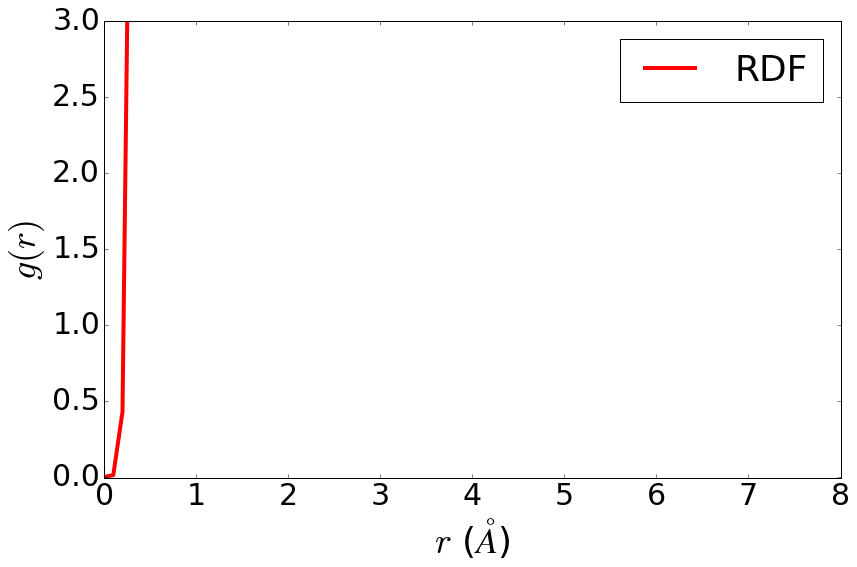

In [14]:
structure_list = [s for s in diffusion_analyzer.get_drift_corrected_structures()]

species = ["O"]
rdf = RadialDistributionFunction(structure_list, ngrid=101, rmax=10.0, cellrange=1, 
                                 sigma=0.1, species = species)
plt = rdf.get_rdf_plot(label="RDF")